## Make predictions with Random Forest Classifier

**Input**:
* Bronze standard set of (non-)SL paralog pairs
* All features (for all paralog pairs)
* Independent data sets of (non-)SL pairs from GI screens

**Output**:
* Random Forest Classifier (pickle)
* Predictions for all paralog pairs (>=20% sequence identity)
* Table S7: Feature values and predictions for all paralog pairs

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import sklearn
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import pickle

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn3_circles

%load_ext autoreload
%autoreload 1
%aimport graphing_params

import itertools
import os


get_local_data_path = lambda folders, fname: os.path.normpath('../local_data/' +'/'.join(folders) +'/'+ fname)

# Inputs
file_features = get_local_data_path([],'feature_list.txt')
file_feature_names = get_local_data_path([],'feature_names.txt')
file_annot_pairs = get_local_data_path(['processed','paralog_features'], 'all_features.csv')
file_paralog_pairs = get_local_data_path(['processed','ensembl93'], 'unique_pairs.csv')
file_depmap_pairs = get_local_data_path(['results'], 'bronze_standard_SL_pairs_24_09_20.csv')
file_thompson_pairs = get_local_data_path(['processed', 'screen_pairs'], 'thompson_pairs.csv')
file_dede_pairs = get_local_data_path(['processed', 'screen_pairs'], 'dede_pairs.csv')
file_validate_SLs = get_local_data_path([], 'validated_SLs.txt')

# Outputs (results)
file_all_predictions = get_local_data_path(['results'], 'predictions_all_pairs.csv')
file_table_s7 = get_local_data_path(['supplemental_files'], 'Table_S7.csv')
file_RF_model = get_local_data_path(['results'], 'RF_model.pickle')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Training & Testing Data

#### Training data + feature annotations for all paralog pairs

In [3]:
all_paralog_annotations = pd.read_csv(file_annot_pairs)
print('Num annotated paralog pairs:', all_paralog_annotations.shape[0])
all_paralog_annotations[:1]

Num annotated paralog pairs: 36648


,A1,A2,A1_ensembl,A2_ensembl,A1_entrez,A2_entrez,closest,min_sequence_identity,max_sequence_identity,WGD,...,has_cerevisiae_ortholog,has_essential_cerevisiae_ortholog,has_single_essential_cerevisiae_ortholog,has_pombe_ortholog,has_essential_pombe_ortholog,has_single_essential_pombe_ortholog,conservation_score,mean_age,colocalisation,same_subcell_loc
0,A1BG,OSCAR,ENSG00000121410,ENSG00000170909,1,126014,False,0.127273,0.22028,False,...,False,False,False,False,False,False,3,210.95,0.0,False


In [4]:
feature_list = pd.read_csv(file_features)
features = list(feature_list[feature_list.include==1].feature)
print('N features', len(features))

N features 22


In [5]:
feature_labels = pd.read_csv(file_feature_names, sep='\t')
feature_labels[:1]

,simple_name,feature,category
0,Sequence Identity,min_sequence_identity,Sequence


In [6]:
depmap_pairs = pd.read_csv(file_depmap_pairs)
depmap_pairs = pd.merge(depmap_pairs, all_paralog_annotations.drop(columns=['A1_ensembl','A2_ensembl','A1_entrez','A2_entrez']))
print('N SL:', depmap_pairs[depmap_pairs.SL].shape[0], '/', depmap_pairs.shape[0])
depmap_pairs[:1]

N SL: 127 / 3637


,A1,A2,SL,A1_ensembl,A2_ensembl,A1_entrez,A2_entrez,closest,min_sequence_identity,max_sequence_identity,...,has_cerevisiae_ortholog,has_essential_cerevisiae_ortholog,has_single_essential_cerevisiae_ortholog,has_pombe_ortholog,has_essential_pombe_ortholog,has_single_essential_pombe_ortholog,conservation_score,mean_age,colocalisation,same_subcell_loc
0,AAK1,BMP2K,False,ENSG00000115977,ENSG00000138756,22848,55589,True,0.341947,0.413111,...,True,False,False,True,False,False,7,976.25,0.0,False


#### Testing data - results from independent combinatorial screens

In [7]:
all_thompson_pairs = pd.read_csv(file_thompson_pairs)
all_thompson_pairs = pd.merge(all_thompson_pairs, all_paralog_annotations)
all_thompson_pairs['SL'] = all_thompson_pairs.n_SL >= 1

# Dataframe that excludes pairs SL in 1 cell line (to test 0 vs. 2+)
thompson_pairs = all_thompson_pairs[(all_thompson_pairs.n_SL>=2) | (all_thompson_pairs.n_SL==0)].reset_index(drop=True)

print('All:', sum(all_thompson_pairs.SL), '/', all_thompson_pairs.shape[0])
print('>=2 or 0:', sum(thompson_pairs.SL), '/', thompson_pairs.shape[0])
thompson_pairs[:1]

All: 71 / 541
>=2 or 0: 23 / 493


,index,A1,A2,GENE PAIR,A375_SL,Mewo_SL,RPE_SL,n_SL,passes_min_1_filter,passes_A375_filter,...,has_essential_cerevisiae_ortholog,has_single_essential_cerevisiae_ortholog,has_pombe_ortholog,has_essential_pombe_ortholog,has_single_essential_pombe_ortholog,conservation_score,mean_age,colocalisation,same_subcell_loc,SL
0,0,CASKIN1,CASKIN2,CASKIN1_CASKIN2,False,False,False,0,True,True,...,False,False,False,False,False,6,842.0,0.0,False,False


In [8]:
all_dede_pairs = pd.read_csv(file_dede_pairs)
all_dede_pairs = pd.merge(all_dede_pairs, all_paralog_annotations)
all_dede_pairs['SL'] = all_dede_pairs.n_SL >= 1

# Dataframe that excludes pairs SL in 1 cell line (to test 0 vs. 2+)
dede_pairs = all_dede_pairs[(all_dede_pairs.n_SL>=2) | (all_dede_pairs.n_SL==0)].reset_index(drop=True)

print('All:', sum(all_dede_pairs.SL), '/', all_dede_pairs.shape[0])
print('>=2 or 0:', sum(dede_pairs.SL), '/', dede_pairs.shape[0])
dede_pairs[:1]

All: 24 / 393
>=2 or 0: 19 / 388


,A1,A2,min_seq_id,pair,A549,HT29,OVCAR8,A549_SL,HT29_SL,OVCAR8_SL,...,has_essential_cerevisiae_ortholog,has_single_essential_cerevisiae_ortholog,has_pombe_ortholog,has_essential_pombe_ortholog,has_single_essential_pombe_ortholog,conservation_score,mean_age,colocalisation,same_subcell_loc,SL
0,SRSF4,SRSF5,0.346154,SRSF4_SRSF5,0.281,0.04,0.853,False,False,False,...,True,True,True,True,False,7,911.3,0.0,False,False


### Drawing code for ROC/PR curves

In [9]:
def draw_roc_curve(data, ypred, ax, label='', color='black', w_seq=True, w_chance=True):
    fpr, tpr, _ = roc_curve(data.SL, ypred)
    line_kwargs = {"drawstyle":"steps-post"}
    ax.step(fpr, tpr, label=label+'(%.2f) ' % (auc(fpr, tpr)), color=color, zorder=10, **line_kwargs)    
    if w_seq:
        fpr_seq_id, tpr_seq_id, _ = roc_curve(data.SL, data.min_sequence_identity)
        ax.step(fpr_seq_id, tpr_seq_id, label='Seq. Id. (%.2f) ' % (auc(fpr_seq_id, tpr_seq_id)), 
                color='#E69F00', **line_kwargs)
    if w_chance:
        ax.plot([0, 1], [0, 1], linestyle='--', color='black', label='Chance (0.50)')
        ax.legend(loc="lower right", bbox_to_anchor=(1.08,0)) 
    ax.set_xlabel('False Positive Rate'); ax.set_ylabel('True Positive Rate')
    ax.set_ylim([-0.05,1.02]); ax.set_xlim([-0.05,1.02])

    
def draw_pr_curve(data, ypred, ax, label='', color='black', w_seq=True, w_chance=True, trim=False):
    precision, recall, _ = precision_recall_curve(data.SL, ypred)
    if trim: precision = precision[:-1]; recall = recall[:-1]
    avg_precision = average_precision_score(data.SL, ypred)
    line_kwargs = {"drawstyle":"steps-post"}
    ax.plot(recall, precision, label=label+'(%.2f) ' % (avg_precision), color=color, **line_kwargs, zorder=10)
    
    if w_seq:
        precision_seq_id, recall_seq_id, _ = precision_recall_curve(data.SL, data.min_sequence_identity)
        recall_seq_id = recall_seq_id[:-1]; precision_seq_id = precision_seq_id[:-1]
        ap_seq_id = average_precision_score(data.SL,  data.min_sequence_identity)
        ax.plot(recall_seq_id, precision_seq_id, label='Seq. Id. (%.2f) ' % (ap_seq_id), color='#E69F00', **line_kwargs)
    if w_chance:
        no_skill = sum(data.SL) / (data.SL).count()
        ax.plot([0, 1], [no_skill, no_skill], linestyle='--', color='black', label='Chance (%.2f)' % (no_skill))
        ax.legend(loc="upper right", bbox_to_anchor=(1.1,1))
    ax.set_xlabel('Recall'); ax.set_ylabel('Precision')
    ax.set_ylim([-0.05,1.02]); ax.set_xlim([-0.05,1.02])
    
def draw_curves(data, ypred, screen, n_SL, ax):
    draw_roc_curve(data, ypred, ax[0], label='RF ')
    draw_pr_curve(data, ypred, ax[1], label='RF ')
    f.suptitle(screen+' screens, SL in '+n_SL+' cell lines (SL='
               +str(sum(data.SL))+', non-SL='+str(sum(~data.SL))+')', 
               fontsize=9, fontweight='bold', horizontalalignment='center')
    plt.tight_layout()

### Train Classifier

In [32]:
RF = RandomForestClassifier(n_estimators=600, random_state=11, max_features=11, max_depth=3, min_samples_leaf=11)
_ = RF.fit(depmap_pairs[features], depmap_pairs.SL)

In [33]:
# Save classifier
# with open(file_RF_model, 'wb') as f:
#     pickle.dump(RF, f)

In [10]:
# Can also load model from file
with open(file_RF_model, 'rb') as f:
    RF = pickle.load(f)

### Validation with genetic interaction screen data
Using data from Thompson et al (2020) and Dede et al (2020)

#### SL in 2+ vs. 0 cell lines

Min threshold for 50%+ precision 0.3408153067226844


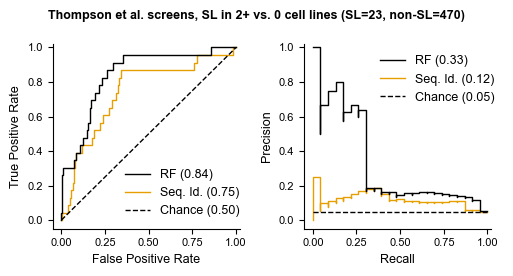

In [17]:
ypred = RF.predict_proba(thompson_pairs[features])[:,1]
P, R, thresholds = precision_recall_curve(thompson_pairs.SL, ypred)
print('Min threshold for 50%+ precision', thresholds[np.argwhere((P >= 0.5) & (P != 1)).min()])

f, ax = plt.subplots(1, 2, figsize=(5.2,2.75))
draw_curves(thompson_pairs, ypred, 'Thompson et al.', '2+ vs. 0', ax)
f.savefig("../figures/for_paper/thompson_roc_pr_2+.svg", bbox_inches="tight", dpi=300)

Min threshold for 50%+ precision 0.2962156574377877


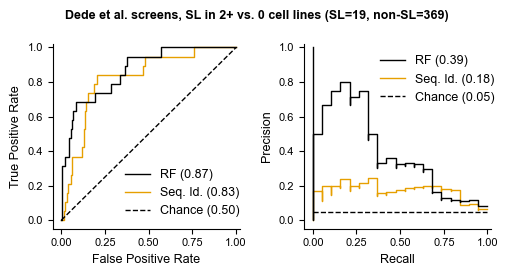

In [18]:
ypred = RF.predict_proba(dede_pairs[features])[:,1]
P, R, thresholds = precision_recall_curve(dede_pairs.SL, ypred)
print('Min threshold for 50%+ precision', thresholds[np.argwhere((P >= 0.5) & (P != 1)).min()])

f, ax = plt.subplots(1, 2, figsize=(5.2,2.75))
draw_curves(dede_pairs, ypred, 'Dede et al.', '2+ vs. 0', ax)
f.savefig("../figures/for_paper/dede_roc_pr_2+.svg", bbox_inches="tight", dpi=300)

#### SL in 1+ vs. 0 cell lines

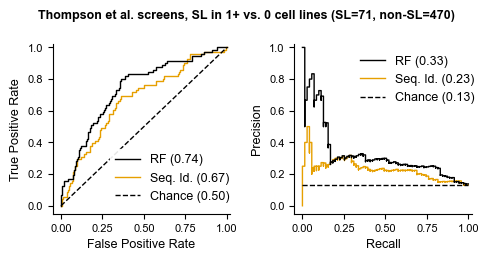

In [19]:
ypred = RF.predict_proba(all_thompson_pairs[features])[:,1]

f, ax = plt.subplots(1, 2, figsize=(5,2.6))
draw_curves(all_thompson_pairs, ypred, 'Thompson et al.', '1+ vs. 0', ax)
f.savefig("../figures/for_paper/thompson_roc_pr_1+.svg", bbox_inches="tight", dpi=300)

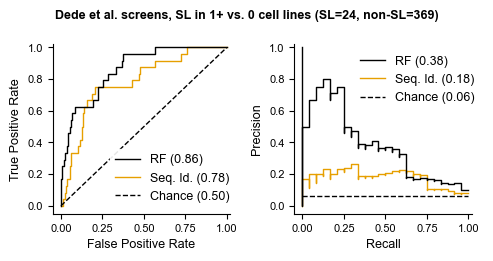

In [20]:
ypred = RF.predict_proba(all_dede_pairs[features])[:,1]

f, ax = plt.subplots(1, 2, figsize=(5,2.6))
draw_curves(all_dede_pairs, ypred, 'Dede et al.', '1+ vs. 0', ax)
f.savefig("../figures/for_paper/dede_roc_pr_1+.svg", bbox_inches="tight", dpi=300)

#### Make predictions only for unseen pairs - i.e. testing data not in the training data

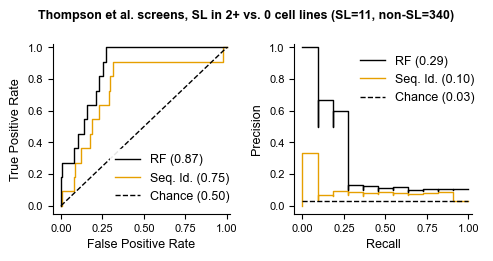

In [21]:
# Drop all overlapping pairs
test_pairs = pd.merge(depmap_pairs[['A1','A2']], thompson_pairs, how='right', indicator=True)
test_pairs = test_pairs[test_pairs._merge=='right_only'].reset_index(drop=True).drop(columns=['_merge'])
ypred = RF.predict_proba(test_pairs[features])[:,1]

f, ax = plt.subplots(1, 2, figsize=(5,2.6))
draw_curves(test_pairs, ypred, 'Thompson et al.', '2+ vs. 0', ax)
f.savefig("../figures/for_paper/thompson_unseen_roc_pr.svg", bbox_inches="tight", dpi=300)

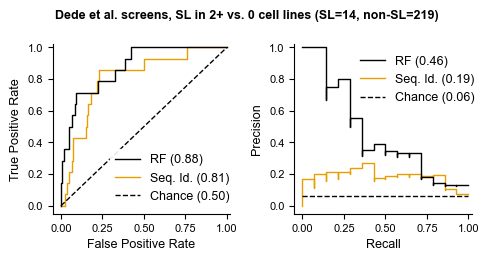

In [22]:
# Drop all overlapping pairs
test_pairs = pd.merge(depmap_pairs[['A1','A2']], dede_pairs, how='right', indicator=True)
test_pairs = test_pairs[test_pairs._merge=='right_only'].reset_index(drop=True).drop(columns=['_merge'])
ypred = RF.predict_proba(test_pairs[features])[:,1]

f, ax = plt.subplots(1, 2, figsize=(5,2.6))
draw_curves(test_pairs, ypred, 'Dede et al.', '2+ vs. 0', ax)
f.savefig("../figures/for_paper/dede_unseen_roc_pr.svg", bbox_inches="tight", dpi=300)

### Predictions for all pairs from Thompson et al.

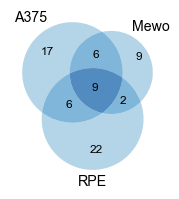

In [23]:
blue_palette = sns.color_palette("Blues", n_colors=4)

def draw_cell_line_venn(sets, labels, ax):
    v = venn3(sets, labels, ax=ax)
    # Color middle patch
    v.get_patch_by_id('111').set_color(blue_palette[3])
    v.get_patch_by_id('111').set_linewidth(0)
    v.get_patch_by_id('111').set_alpha(0.75)
    # Color other patches
    for id in ['110', '101', '011']: 
        v.get_patch_by_id(id).set_color(blue_palette[2])
        v.get_patch_by_id(id).set_linewidth(0)
        v.get_patch_by_id(id).set_alpha(0.7)
    for id in ['100', '001', '010']: 
        v.get_patch_by_id(id).set_color(blue_palette[1])
        v.get_patch_by_id(id).set_linewidth(0)
        v.get_patch_by_id(id).set_alpha(0.7)
        
# Number of paralog pairs SL in each of the screened cell lines
set1 = set(all_thompson_pairs[all_thompson_pairs.A375_SL]['GENE PAIR'].values)
set2 = set(all_thompson_pairs[all_thompson_pairs.Mewo_SL]['GENE PAIR'].values)
set3 = set(all_thompson_pairs[all_thompson_pairs.RPE_SL]['GENE PAIR'].values)
    
with plt.rc_context({'font.size':8.5}):
    f, ax = plt.subplots(1, 1, figsize=(2,3))
    draw_cell_line_venn([set1, set2, set3], ['A375','Mewo', 'RPE'], ax)
    f.savefig("../figures/for_paper/thompson_venn.svg", bbox_inches="tight", dpi=300)

In [24]:
ypred = RF.predict_proba(all_thompson_pairs[features])[:,1]
thompson_predictions = all_thompson_pairs.assign(SL_pred=ypred)

for (i,j) in itertools.combinations([0,1,2,3], 2):
    print('%d v %d Mann-U' % (i,j), 
          'stat=%.1f, pval=%.3e' % (stats.mannwhitneyu(thompson_predictions[thompson_predictions.n_SL==i].SL_pred,
                                                       thompson_predictions[thompson_predictions.n_SL==j].SL_pred)))    
print('1 v 2+ Mann-U', 
      'stat=%.1f, pval=%.3e' % (stats.mannwhitneyu(thompson_predictions[thompson_predictions.n_SL==1].SL_pred,
                                                   thompson_predictions[thompson_predictions.n_SL>1].SL_pred)))

0 v 1 Mann-U stat=7014.0, pval=7.864e-06
0 v 2 Mann-U stat=1278.0, pval=4.799e-05
0 v 3 Mann-U stat=424.0, pval=1.980e-05
1 v 2 Mann-U stat=233.0, pval=4.220e-02
1 v 3 Mann-U stat=91.0, pval=3.219e-03
2 v 3 Mann-U stat=47.0, pval=1.644e-01
1 v 2+ Mann-U stat=324.0, pval=2.593e-03


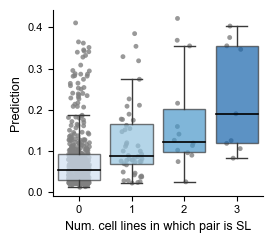

In [25]:
f, ax = plt.subplots(1, 1, figsize=(2.8,2.5))
sns.boxplot(y='SL_pred', x='n_SL', data=thompson_predictions, palette=blue_palette, ax=ax, linewidth=1, 
            showfliers=False, saturation=1, boxprops=dict(alpha=0.7), medianprops=dict(linewidth=1.2, color='black'))
sns.stripplot(y='SL_pred', x='n_SL', data=thompson_predictions, color='grey', ax=ax, alpha=0.8, size=3.5, zorder=0, jitter=0.2)
ax.set_xlabel('Num. cell lines in which pair is SL'); ax.set_ylabel('Prediction')
plt.tight_layout()
f.savefig("../figures/for_paper/thompson_boxplots.svg", bbox_inches="tight", dpi=300)

### Predictions for all pairs from Dede et al.

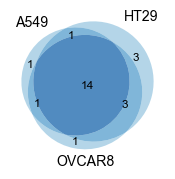

In [26]:
# Number of paralog pairs SL in each of the screened cell lines
set1 = set(all_dede_pairs[all_dede_pairs.A549_SL]['pair'].values)
set2 = set(all_dede_pairs[all_dede_pairs.HT29_SL]['pair'].values)
set3 = set(all_dede_pairs[all_dede_pairs.OVCAR8_SL]['pair'].values)
    
with plt.rc_context({'font.size':8.5}):
    f, ax = plt.subplots(1, 1, figsize=(2,3))
    draw_cell_line_venn([set1, set2, set3], ['A549','HT29', 'OVCAR8'], ax)
    f.savefig("../figures/for_paper/dede_venn.svg", bbox_inches="tight", dpi=300)

In [27]:
ypred = RF.predict_proba(all_dede_pairs[features])[:,1]
dede_predictions = all_dede_pairs.assign(SL_pred=ypred)

print('0 v 1 Mann-U stat=%.1f, pval=%.5f' % 
      (stats.mannwhitneyu(dede_predictions[dede_predictions.n_SL==0].SL_pred, 
                          dede_predictions[(dede_predictions.n_SL>=1) & (dede_predictions.n_SL<=2)].SL_pred)))
print('1-2 v 3 Mann-U stat=%.1f, pval=%.3f' % 
      (stats.mannwhitneyu(dede_predictions[(dede_predictions.n_SL>=1) & (dede_predictions.n_SL<=2)].SL_pred,
                          dede_predictions[dede_predictions.n_SL==3].SL_pred)))

0 v 1 Mann-U stat=596.0, pval=0.00013
1-2 v 3 Mann-U stat=51.0, pval=0.139


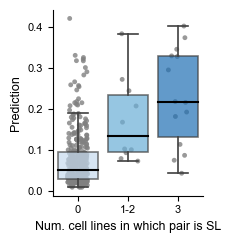

In [29]:
f, ax = plt.subplots(1, 1, figsize=(2.2,2.5))
# Merge n_SL for 1 and 2
df = dede_predictions.assign(n_SL = dede_predictions['n_SL'].apply(lambda x: 1 if x==2 else x))
sns.boxplot(y='SL_pred', x='n_SL', data=df, palette=sns.color_palette("Blues", n_colors=3), ax=ax, linewidth=1.2, 
            showfliers=False, saturation=1, boxprops=dict(alpha=0.7), medianprops=dict(linewidth=1.5, color='black'))
sns.stripplot(y='SL_pred', x='n_SL', data=df, color='grey', ax=ax, alpha=0.8, size=3.5, zorder=0, jitter=0.2)
ax.set_xlabel('Num. cell lines in which pair is SL'); ax.set_ylabel('Prediction')
ax.set_xticklabels(['0','1-2','3'])
plt.tight_layout()
f.savefig("../figures/for_paper/dede_boxplots.svg", bbox_inches="tight", dpi=300)

### Predictions for all ~36.6k paralog pairs

In [94]:
ypred = RF.predict_proba(all_paralog_annotations[features])[:,1]
all_predictions = all_paralog_annotations[['A1','A2','A1_entrez','A2_entrez']].assign(prediction_score=ypred)
all_predictions = all_predictions.sort_values('prediction_score', ascending=False)

print('Mean prediction: %.4f, median: %.4f' % (all_predictions.prediction_score.mean(), 
                                               all_predictions.prediction_score.median()))

# Annotate the predictions dataframe: note for each pair whether it was a previously validated SL 
validated_SLs = pd.read_csv(file_validate_SLs)
all_predictions = pd.merge(all_predictions, validated_SLs, how='left', indicator='validated_SL')
all_predictions['validated_SL'] = all_predictions['validated_SL'] == 'both'

# Add column for prediction rank
all_predictions = all_predictions.reset_index().rename(columns={'index':'prediction_rank'})
all_predictions['prediction_rank'] = all_predictions['prediction_rank']+1
assert(all_predictions[all_predictions.validated_SL==True].shape[0] == 12)

all_predictions[:2]

Mean prediction: 0.0270, median: 0.0185


,prediction_rank,A1,A2,A1_entrez,A2_entrez,prediction_score,validated_SL
0,1,SMARCA2,SMARCA4,6595,6597,0.422009,True
1,2,EXOC6,EXOC6B,54536,23233,0.411136,False


In [236]:
# Save predictions
all_predictions.to_csv(file_all_predictions, index=0)

In [30]:
# Load predictions
all_predictions = pd.read_csv(file_all_predictions)

In [96]:
# Table S7: all predictions and all feature values
tab_s7 = pd.merge(all_predictions.drop(columns=['validated_SL']), all_paralog_annotations[['A1','A2']+features])
display(tab_s7[:2])
tab_s7.to_csv(file_table_s7, index=0)

,prediction_rank,A1,A2,A1_entrez,A2_entrez,prediction_score,min_sequence_identity,closest,WGD,family_size,...,either_in_complex,mean_complex_essentiality,colocalisation,interact,n_total_ppi,fet_ppi_overlap,shared_ppi_mean_essentiality,gtex_spearman_corr,gtex_min_mean_expr,gtex_max_mean_expr
0,1,SMARCA2,SMARCA4,6595,6597,0.422009,0.746812,True,True,2,...,True,0.387167,0.333333,True,303.0,114.476774,0.225344,0.627875,18.609973,34.302868
1,2,EXOC6,EXOC6B,54536,23233,0.411136,0.698159,True,True,2,...,True,0.487019,0.250000,True,54.0,29.644986,0.285886,0.069456,6.390812,11.168367


### Waterfall plot of all predictions

% with a prediction above 0.1: 0.03127
Lowest score in top ~3.5% 0.09202776957180987


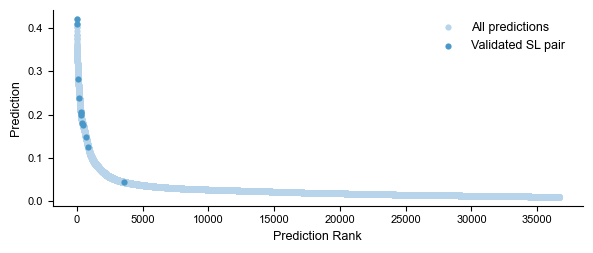

In [31]:
# Waterfall plot of all predictions, with validated SLs highlighted
df = all_predictions
print('%% with a prediction above 0.1: %.5f' % (df[df.prediction_score > 0.1].shape[0] / df.shape[0]))
print('Lowest score in top ~3.5%', df[:int(0.035*df.shape[0])].prediction_score.min())

f, ax1 = plt.subplots(1, 1, figsize=(6,2.6))
pal = sns.color_palette("Blues", n_colors=9)
sns.scatterplot(df.index, df.prediction_score, ax=ax1, linewidth=0, s=20, alpha=1, color=pal[2], label="All predictions  ")
sns.scatterplot(df[df.validated_SL].index, df[df.validated_SL].prediction_score, ax=ax1, linewidth=0, s=20, alpha=1,
                color=pal[5], label="Validated SL pair  ")
ax1.set_ylabel('Prediction')
ax1.set_xlabel('Prediction Rank')
ax1.legend()
plt.tight_layout()